In [1]:
# ignore
import re
from word2number import w2n

unit_texts = [
    "east",
    "degree",
    "mph",
    "kmph",
    "ft",
    "m sqaure",
    " m east",
    "sq m",
    "deg",
    "mile",
    "q .",
    "monkey",
    "prime",
    "ratio",
    "profit of rs",
    "rd",
    "o",
    "gm",
    "p . m",
    "lb",
    "tile",
    "per",
    "dm",
    "lt",
    "gain",
    "ab",
    "way",
    "west",
    "a .",
    "b .",
    "c .",
    "d .",
    "e .",
    "f .",
    "g .",
    "h .",
    "t",
    "a",
    "h",
    "no change",
    "men",
    "soldier",
    "pie",
    "bc",
    "excess",
    "st",
    "inches",
    "noon",
    "percent",
    "by",
    "gal",
    "kmh",
    "c",
    "acre",
    "rise",
    "a . m",
    "th",
    "π r 2",
    "sq",
    "mark",
    "l",
    "toy",
    "coin",
    "sq . m",
    "gallon",
    "° f",
    "profit",
    "minw",
    "yr",
    "women",
    "feet",
    "am",
    "pm",
    "hr",
    "cu cm",
    "square",
    "v â € ™",
    "are",
    "rupee",
    "rounds",
    "cubic",
    "cc",
    "mtr",
    "s",
    "ohm",
    "number",
    "kmph",
    "day",
    "hour",
    "minute",
    "min",
    "second",
    "man",
    "woman",
    "sec",
    "cube",
    "mt",
    "sq inch",
    "mp",
    "∏ cm ³",
    "hectare",
    "more",
    "sec",
    "unit",
    "cu . m",
    "cm 2",
    "rs .",
    "rs",
    "kg",
    "g",
    "month",
    "km",
    "m",
    "cm",
    "mm",
    "apple",
    "liter",
    "loss",
    "yard",
    "pure",
    "year",
    "increase",
    "decrease",
    "d",
    "less",
    "Surface",
    "litre",
    "pi sq m",
    "s .",
    "metre",
    "meter",
    "inch",
]

unit_texts.extend([t + "s" for t in unit_texts])

def _fix_fracs(string):
    substrs = string.split("\\frac")
    new_str = substrs[0]
    if len(substrs) > 1:
        substrs = substrs[1:]
        for substr in substrs:
            new_str += "\\frac"
            if len(substr) > 0 and substr[0] == "{":
                new_str += substr
            else:
                try:
                    assert len(substr) >= 2
                except:
                    return string
                a = substr[0]
                b = substr[1]
                if b != "{":
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}{" + b + "}" + post_substr
                    else:
                        new_str += "{" + a + "}{" + b + "}"
                else:
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}" + b + post_substr
                    else:
                        new_str += "{" + a + "}" + b
    string = new_str
    return string


def _fix_a_slash_b(string):
    if len(string.split("/")) != 2:
        return string
    a = string.split("/")[0]
    b = string.split("/")[1]
    try:
        if "sqrt" not in a:
            a = int(a)
        if "sqrt" not in b:
            b = int(b)
        assert string == "{}/{}".format(a, b)
        new_string = "\\frac{" + str(a) + "}{" + str(b) + "}"
        return new_string
    except:
        return string


def _fix_sqrt(string):
    _string = re.sub(r"\\sqrt(\w+)", r"\\sqrt{\1}", string)
    return _string


def convert_word_number(text: str) -> str:
    try:
        text = str(w2n.word_to_num(text))
    except:
        pass
    return text

def strip_string(string, skip_unit=False):
    string = str(string).strip()
    # linebreaks
    string = string.replace("\n", "")

    # right "."
    string = string.rstrip(".")

    # remove inverse spaces
    # replace \\ with \
    string = string.replace("\\!", "")
    # string = string.replace("\\ ", "")
    # string = string.replace("\\\\", "\\")

    # matrix
    string = re.sub(r"\\begin\{array\}\{.*?\}", r"\\begin{pmatrix}", string)
    string = re.sub(r"\\end\{array\}", r"\\end{pmatrix}", string)
    string = string.replace("bmatrix", "pmatrix")

    # replace tfrac and dfrac with frac
    string = string.replace("tfrac", "frac")
    string = string.replace("dfrac", "frac")
    string = (
        string.replace("\\neq", "\\ne")
        .replace("\\leq", "\\le")
        .replace("\\geq", "\\ge")
    )

    # remove \left and \right
    string = string.replace("\\left", "")
    string = string.replace("\\right", "")
    string = string.replace("\\{", "{")
    string = string.replace("\\}", "}")

    # Remove unit: miles, dollars if after is not none
    _string = re.sub(r"\\text{.*?}$", "", string).strip()
    if _string != "" and _string != string:
        # print("Warning: unit not removed: '{}' -> '{}'".format(string, _string))
        string = _string

    if not skip_unit:
        # Remove unit: texts
        for _ in range(2):
            for unit_text in unit_texts:
                # use regex, the prefix should be either the start of the string or a non-alphanumeric character
                # the suffix should be either the end of the string or a non-alphanumeric character
                _string = re.sub(r"(^|\W)" + unit_text + r"($|\W)", r"\1\2", string)
                if _string != "":
                    string = _string

    # Remove circ (degrees)
    string = string.replace("^{\\circ}", "")
    string = string.replace("^\\circ", "")

    # remove dollar signs
    string = string.replace("\\$", "")
    string = string.replace("$", "")
    string = string.replace("\\(", "").replace("\\)", "")

    # convert word number to digit
    string = convert_word_number(string)

    # replace "\\text{...}" to "..."
    string = re.sub(r"\\text\{(.*?)\}", r"\1", string)
    for key in ["x=", "y=", "z=", "x\\in", "y\\in", "z\\in", "x\\to", "y\\to", "z\\to"]:
        string = string.replace(key, "")
    string = string.replace("\\emptyset", r"{}")
    string = string.replace("(-\\infty,\\infty)", "\\mathbb{R}")

    # remove percentage
    string = string.replace("\\%", "")
    string = string.replace("\%", "")
    string = string.replace("%", "")

    # " 0." equivalent to " ." and "{0." equivalent to "{." Alternatively, add "0" if "." is the start of the string
    string = string.replace(" .", " 0.")
    string = string.replace("{.", "{0.")

    # cdot
    # string = string.replace("\\cdot", "")
    if (
        string.startswith("{")
        and string.endswith("}")
        and string.isalnum()
        or string.startswith("(")
        and string.endswith(")")
        and string.isalnum()
        or string.startswith("[")
        and string.endswith("]")
        and string.isalnum()
    ):
        string = string[1:-1]

    # inf
    string = string.replace("infinity", "\\infty")
    if "\\infty" not in string:
        string = string.replace("inf", "\\infty")
    string = string.replace("+\\inity", "\\infty")

    # and
    string = string.replace("and", "")
    string = string.replace("\\mathbf", "")

    # use regex to remove \mbox{...}
    string = re.sub(r"\\mbox{.*?}", "", string)

    # quote
    string.replace("'", "")
    string.replace('"', "")

    # i, j
    if "j" in string and "i" not in string:
        string = string.replace("j", "i")

    # replace a.000b where b is not number or b is end, with ab, use regex
    string = re.sub(r"(\d+)\.0*([^\d])", r"\1\2", string)
    string = re.sub(r"(\d+)\.0*$", r"\1", string)

    # if empty, return empty string
    if len(string) == 0:
        return string
    if string[0] == ".":
        string = "0" + string

    # to consider: get rid of e.g. "k = " or "q = " at beginning
    if len(string.split("=")) == 2:
        if len(string.split("=")[0]) <= 2:
            string = string.split("=")[1]

    string = _fix_sqrt(string)
    string = string.replace(" ", "")

    # \frac1b or \frac12 --> \frac{1}{b} and \frac{1}{2}, etc. Even works with \frac1{72} (but not \frac{72}1). Also does a/b --> \\frac{a}{b}
    string = _fix_fracs(string)

    # NOTE: X/Y changed to \frac{X}{Y} in dataset, but in simple cases fix in case the model output is X/Y
    string = _fix_a_slash_b(string)

    return string

def extract_answer(pred_str, data_name="math", use_last_number=True):
    pred_str = pred_str.replace("\u043a\u0438", "")

    if "final answer is $" in pred_str and "$. I hope" in pred_str:
        # minerva_math
        tmp = pred_str.split("final answer is $", 1)[1]
        pred = tmp.split("$. I hope", 1)[0].strip()
    elif "boxed" in pred_str:
        ans = pred_str.split("boxed")[-1]
        if len(ans) == 0:
            return ""
        elif ans[0] == "{":
            stack = 1
            a = ""
            for c in ans[1:]:
                if c == "{":
                    stack += 1
                    a += c
                elif c == "}":
                    stack -= 1
                    if stack == 0:
                        break
                    a += c
                else:
                    a += c
        else:
            a = ans.split("$")[0].strip()
        pred = a
    elif "he answer is" in pred_str:
        pred = pred_str.split("he answer is")[-1].strip()
    elif "final answer is" in pred_str:
        pred = pred_str.split("final answer is")[-1].strip()
    elif "答案是" in pred_str:
        # Handle Chinese few-shot multiple choice problem answer extraction
        pred = pred_str.split("答案是")[1].strip().split("\n\n")[0].strip()
    else:  # use the last number
        if use_last_number:
            pattern = "-?\d*\.?\d+"
            pred = re.findall(pattern, pred_str.replace(",", ""))
            if len(pred) >= 1:
                pred = pred[-1]
            else:
                pred = ""
        else:
            pred = ""

    # choice answer
    if (
        data_name in ["sat_math", "aqua"]
        or "mmlu" in data_name
    ):
        tmp = re.findall(r"\b(A|B|C|D|E)\b", pred.upper())
        if tmp:
            pred = tmp[-1]
        else:
            pred = pred.strip().strip(".")

    # multiple line
    # pred = pred.split("\n")[0]
    pred = re.sub(r"\n\s*", "", pred)
    if pred != "" and pred[0] == ":":
        pred = pred[1:]
    if pred != "" and pred[-1] == ".":
        pred = pred[:-1]
    if pred != "" and pred[-1] == "/":
        pred = pred[:-1]
    pred = strip_string(pred, skip_unit=data_name in ["carp_en", "minerva_math"])
    return pred



In [2]:
#ignore
"""
This logic is largely copied from the Hendrycks' MATH release (math_equivalence), and borrowed from:
- https://github.com/microsoft/ProphetNet/tree/master/CRITIC
- https://github.com/openai/prm800k
- https://github.com/microsoft/ToRA/blob/main/src/eval/grader.py
- https://github.com/deepseek-ai/DeepSeek-Math/blob/main/evaluation/eval/eval_utils.py
"""

import re
import regex
import multiprocessing
from math import isclose
from typing import Union
from collections import defaultdict

from sympy import simplify, N
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.latex import parse_latex
from latex2sympy2 import latex2sympy

# from .parser import choice_answer_clean, strip_string
# from parser import choice_answer_clean


def choice_answer_clean(pred: str):
    pred = pred.strip("\n").rstrip(".").rstrip("/").strip(" ").lstrip(":")
    # Clean the answer based on the dataset
    tmp = re.findall(r"\b(A|B|C|D|E)\b", pred.upper())
    if tmp:
        pred = tmp
    else:
        pred = [pred.strip().strip(".")]
    pred = pred[-1]
    # Remove the period at the end, again!
    pred = pred.rstrip(".").rstrip("/")
    return pred


def parse_digits(num):
    num = regex.sub(",", "", str(num))
    try:
        return float(num)
    except:
        if num.endswith("%"):
            num = num[:-1]
            if num.endswith("\\"):
                num = num[:-1]
            try:
                return float(num) / 100
            except:
                pass
    return None


def is_digit(num):
    # paired with parse_digits
    return parse_digits(num) is not None


def str_to_pmatrix(input_str):
    input_str = input_str.strip()
    matrix_str = re.findall(r"\{.*,.*\}", input_str)
    pmatrix_list = []

    for m in matrix_str:
        m = m.strip("{}")
        pmatrix = r"\begin{pmatrix}" + m.replace(",", "\\") + r"\end{pmatrix}"
        pmatrix_list.append(pmatrix)

    return ", ".join(pmatrix_list)


def math_equal(
    prediction: Union[bool, float, str],
    reference: Union[float, str],
    include_percentage: bool = True,
    is_close: bool = True,
    timeout: bool = False,
) -> bool:
    """
    Exact match of math if and only if:
    1. numerical equal: both can convert to float and are equal
    2. symbolic equal: both can convert to sympy expression and are equal
    """
    # print("Judge:", prediction, reference)
    if prediction is None or reference is None:
        return False
    if str(prediction.strip().lower()) == str(reference.strip().lower()):
        return True
    if (
        reference in ["A", "B", "C", "D", "E"]
        and choice_answer_clean(prediction) == reference
    ):
        return True

    try:  # 1. numerical equal
        if is_digit(prediction) and is_digit(reference):
            prediction = parse_digits(prediction)
            reference = parse_digits(reference)
            # number questions
            if include_percentage:
                gt_result = [reference / 100, reference, reference * 100]
            else:
                gt_result = [reference]
            for item in gt_result:
                try:
                    if is_close:
                        if numeric_equal(prediction, item):
                            return True
                    else:
                        if item == prediction:
                            return True
                except Exception:
                    continue
            return False
    except:
        pass

    if not prediction and prediction not in [0, False]:
        return False

    # 2. symbolic equal
    reference = str(reference).strip()
    prediction = str(prediction).strip()

    ## pmatrix (amps)
    if "pmatrix" in prediction and not "pmatrix" in reference:
        reference = str_to_pmatrix(reference)

    ## deal with [], (), {}
    pred_str, ref_str = prediction, reference
    if (
        prediction.startswith("[")
        and prediction.endswith("]")
        and not reference.startswith("(")
    ) or (
        prediction.startswith("(")
        and prediction.endswith(")")
        and not reference.startswith("[")
    ):
        pred_str = pred_str.strip("[]()")
        ref_str = ref_str.strip("[]()")
    for s in ["{", "}", "(", ")"]:
        ref_str = ref_str.replace(s, "")
        pred_str = pred_str.replace(s, "")
    if pred_str.lower() == ref_str.lower():
        return True

    ## [a, b] vs. [c, d], return a==c and b==d
    if (
        regex.match(r"(\(|\[).+(\)|\])", prediction) is not None
        and regex.match(r"(\(|\[).+(\)|\])", reference) is not None
    ):
        pred_parts = prediction[1:-1].split(",")
        ref_parts = reference[1:-1].split(",")
        if len(pred_parts) == len(ref_parts):
            if all(
                [
                    math_equal(
                        pred_parts[i], ref_parts[i], include_percentage, is_close
                    )
                    for i in range(len(pred_parts))
                ]
            ):
                return True
    if (
        (
            prediction.startswith("\\begin{pmatrix}")
            or prediction.startswith("\\begin{bmatrix}")
        )
        and (
            prediction.endswith("\\end{pmatrix}")
            or prediction.endswith("\\end{bmatrix}")
        )
        and (
            reference.startswith("\\begin{pmatrix}")
            or reference.startswith("\\begin{bmatrix}")
        )
        and (
            reference.endswith("\\end{pmatrix}") or reference.endswith("\\end{bmatrix}")
        )
    ):
        pred_lines = [
            line.strip()
            for line in prediction[
                len("\\begin{pmatrix}") : -len("\\end{pmatrix}")
            ].split("\\\\")
            if line.strip()
        ]
        ref_lines = [
            line.strip()
            for line in reference[
                len("\\begin{pmatrix}") : -len("\\end{pmatrix}")
            ].split("\\\\")
            if line.strip()
        ]
        matched = True
        if len(pred_lines) == len(ref_lines):
            for pred_line, ref_line in zip(pred_lines, ref_lines):
                pred_parts = pred_line.split("&")
                ref_parts = ref_line.split("&")
                if len(pred_parts) == len(ref_parts):
                    if not all(
                        [
                            math_equal(
                                pred_parts[i],
                                ref_parts[i],
                                include_percentage,
                                is_close,
                            )
                            for i in range(len(pred_parts))
                        ]
                    ):
                        matched = False
                        break
                else:
                    matched = False
                if not matched:
                    break
        else:
            matched = False
        if matched:
            return True

    if prediction.count("=") == 1 and reference.count("=") == 1:
        pred = prediction.split("=")
        pred = f"{pred[0].strip()} - ({pred[1].strip()})"
        ref = reference.split("=")
        ref = f"{ref[0].strip()} - ({ref[1].strip()})"
        if symbolic_equal(pred, ref) or symbolic_equal(f"-({pred})", ref):
            return True
    elif (
        prediction.count("=") == 1
        and len(prediction.split("=")[0].strip()) <= 2
        and "=" not in reference
    ):
        if math_equal(
            prediction.split("=")[1], reference, include_percentage, is_close
        ):
            return True
    elif (
        reference.count("=") == 1
        and len(reference.split("=")[0].strip()) <= 2
        and "=" not in prediction
    ):
        if math_equal(
            prediction, reference.split("=")[1], include_percentage, is_close
        ):
            return True

    # symbolic equal with sympy
    if timeout:
        if call_with_timeout(symbolic_equal_process, prediction, reference):
            return True
    else:
        if symbolic_equal(prediction, reference):
            return True

    return False


def math_equal_process(param):
    return math_equal(param[-2], param[-1])


def numeric_equal(prediction: float, reference: float):
    # Note that relative tolerance has significant impact
    # on the result of the synthesized GSM-Hard dataset
    # if reference.is_integer():
    #     return isclose(reference, round(prediction), abs_tol=1e-4)
    # else:
    # prediction = round(prediction, len(str(reference).split(".")[-1]))
    return isclose(reference, prediction, rel_tol=1e-4)


def symbolic_equal(a, b):
    def _parse(s):
        for f in [parse_latex, parse_expr, latex2sympy]:
            try:
                return f(s.replace("\\\\", "\\"))
            except:
                try:
                    return f(s)
                except:
                    pass
        return s

    a = _parse(a)
    b = _parse(b)

    # direct equal
    try:
        if str(a) == str(b) or a == b:
            return True
    except:
        pass

    # simplify equal
    try:
        if a.equals(b) or simplify(a - b) == 0:
            return True
    except:
        pass

    # equation equal
    try:
        if (abs(a.lhs - a.rhs)).equals(abs(b.lhs - b.rhs)):
            return True
    except:
        pass

    try:
        if numeric_equal(float(N(a)), float(N(b))):
            return True
    except:
        pass

    # matrix
    try:
        # if a and b are matrix
        if a.shape == b.shape:
            _a = a.applyfunc(lambda x: round(x, 3))
            _b = b.applyfunc(lambda x: round(x, 3))
            if _a.equals(_b):
                return True
    except:
        pass

    return False


def symbolic_equal_process(a, b, output_queue):
    result = symbolic_equal(a, b)
    output_queue.put(result)


def call_with_timeout(func, *args, timeout=1, **kwargs):
    output_queue = multiprocessing.Queue()
    process_args = args + (output_queue,)
    process = multiprocessing.Process(target=func, args=process_args, kwargs=kwargs)
    process.start()
    process.join(timeout)

    if process.is_alive():
        process.terminate()
        process.join()
        return False

    return output_queue.get()

def _test_math_equal():
    # print(math_equal("0.0833333333333333", "\\frac{1}{12}"))
    # print(math_equal("(1,4.5)", "(1,\\frac{9}{2})"))
    # print(math_equal("\\frac{x}{7}+\\frac{2}{7}", "\\frac{x+2}{7}", timeout=True))
    # print(math_equal("\\sec^2(y)", "\\tan^2(y)+1", timeout=True))
    # print(math_equal("\\begin{pmatrix}-\\frac{7}{4}&-2\\\\4&\\frac{1}{4}\\end{pmatrix}", "(\\begin{pmatrix}-\\frac{7}{4}&-2\\\\4&\\frac{1}{4}\\\\\\end{pmatrix})", timeout=True))

    # pred = '\\begin{pmatrix}\\frac{1}{3x^{2/3}}&0&0\\\\0&1&0\\\\-\\sin(x)&0&0\\end{pmatrix}'
    # gt = '(\\begin{pmatrix}\\frac{1}{3\\sqrt[3]{x}^2}&0&0\\\\0&1&0\\\\-\\sin(x)&0&0\\\\\\end{pmatrix})'

    # pred= '-\\frac{8x^2}{9(x^2-2)^{5/3}}+\\frac{2}{3(x^2-2)^{2/3}}'
    # gt= '-\\frac{2(x^2+6)}{9(x^2-2)\\sqrt[3]{x^2-2}^2}'

    # pred =  '-34x-45y+20z-100=0'
    # gt = '34x+45y-20z+100=0'

    # pred = '\\frac{100}{3}'
    # gt = '33.3'

    # pred = '\\begin{pmatrix}0.290243531202435\\\\0.196008371385084\\\\-0.186381278538813\\end{pmatrix}'
    # gt = '(\\begin{pmatrix}0.29\\\\0.196\\\\-0.186\\\\\\end{pmatrix})'

    # pred = '\\frac{\\sqrt{\\sqrt{11}+\\sqrt{194}}}{2\\sqrt{33}+15}'
    # gt = '\\frac{\\sqrt{\\sqrt{11}+\\sqrt{194}}}{15+2\\sqrt{33}}'

    # pred = '(+5)(b+2)'
    # gt = '(a+5)(b+2)'

    # pred = '\\frac{1+\\sqrt{5}}{2}'
    # gt = '2'

    # pred = '\\frac{34}{16}+\\frac{\\sqrt{1358}}{16}', gt = '4'
    # pred = '1', gt = '1\\\\sqrt{19}'

    # pred = "(0.6,2.6667]"
    # gt = "(\\frac{3}{5},\\frac{8}{3}]"

    gt = "x+2n+1"
    pred = "x+1"

    print(math_equal(pred, gt, timeout=True))


In [3]:
# Replace the jsonl file here

import os
import json
import random
import json
import os
import numpy as np
from pathlib import Path
from typing import Iterable, Union, Any

def load_jsonl(file: Union[str, Path]) -> Iterable[Any]:
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                yield json.loads(line)
            except:
                print("Error in loading:", line)
                exit()

output_path = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n4.jsonl"
output_path_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n8_b0.001.jsonl"
output_path_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n8_b0.1.jsonl"
output_path_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.01.jsonl"
output_path_5 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b1.jsonl"
output_path_6 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.1.jsonl"
bon = "/data/nived/mert/spec/search-and-learn/data/best_of_n/AMead10Llama-3.2-3B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.1.jsonl"
bon_base = "/data/nived/mert/spec/search-and-learn/data/best_of_n/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-1B-Instruct-AWQ_n16_b0.1.jsonl"
bs = "/data/nived/mert/spec/search-and-learn/data/beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.1.jsonl"
bs_base = "/data/nived/mert/spec/search-and-learn/data/beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-1B-Instruct-AWQ_n16_b0.1.jsonl"
output_path_7 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.05.jsonl"
output_path_8 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b5.jsonl"
output_path_9 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b5000.jsonl"
sanity = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-1B-Instruct-AWQ_n16_b9999999999.jsonl"
sanity_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b9999999999.jsonl"
sanity_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b9999999999.jsonl"
sanity_bs = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b123.jsonl"
sanity_bs_3_new_rm = '/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b125.jsonl'
sanity_bs_1_new_rm = '/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b127.jsonl'
samples_sanity_bs_1 = list(load_jsonl(sanity_bs))
samples_sanity_bs_3 = list(load_jsonl(sanity_3))
samples_sanity_bs_1_new_rm = list(load_jsonl(sanity_bs_1_new_rm))
samples_sanity_bs_3_new_rm = list(load_jsonl(sanity_bs_3_new_rm))
samples_bs_1 = list(load_jsonl(bs_base))
samples_bs_3 = list(load_jsonl(bs))
samples_bon_1 = list(load_jsonl(bon_base))
samples_bon_3 = list(load_jsonl(bon))

FileNotFoundError: [Errno 2] No such file or directory: '/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b123.jsonl'

In [4]:
bon_100 = "/data/nived/mert/spec/search-and-learn/data/best_of_n/AMead10Llama-3.2-3B-Instruct-AWQ-_n16_b0.1_q100.jsonl"
bs_100 = "/data/nived/mert/spec/search-and-learn/data/beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-_n16_b0.1_q100.jsonl"
new_sa_20_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.1_q20.jsonl"
new_sa_20_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.5_q20.jsonl"
new_sa_20_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b1.0_q20.jsonl"
samples_bs_100 = list(load_jsonl(bs_100))
samples_bon_100 = list(load_jsonl(bon_100))
samples_new_sa_20_1 = list(load_jsonl(new_sa_20_1))
samples_new_sa_20_2 = list(load_jsonl(new_sa_20_2))
samples_new_sa_20_3 = list(load_jsonl(new_sa_20_3))
new_sa_100_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.1_q100.jsonl"
new_sa_100_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b1.0_q100.jsonl"
new_sa_100_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b1.2_q100.jsonl"
new_sa_100_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.5_q100.jsonl"
new_sa_100_5 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b0.8_q100.jsonl"
new_sa_100_6 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b1.1_q100.jsonl"
new_sa_100_7 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-AMead10Llama-3.2-3B-Instruct-AWQ_n16_b2.0_q100.jsonl"
samples_new_sa_100_1 = list(load_jsonl(new_sa_100_1))
samples_new_sa_100_2 = list(load_jsonl(new_sa_100_2))
samples_new_sa_100_3 = list(load_jsonl(new_sa_100_3))
samples_new_sa_100_4 = list(load_jsonl(new_sa_100_4))
samples_new_sa_100_5 = list(load_jsonl(new_sa_100_5))
samples_new_sa_100_6 = list(load_jsonl(new_sa_100_6))
samples_new_sa_100_7 = list(load_jsonl(new_sa_100_7))
sa_1b_8b_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n16_b0.8_q20.jsonl"
sa_1b_8b_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b0.2_q20.jsonl"
sa_1b_8b_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.5_q20.jsonl"
sa_1b_8b_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b2.0_q20.jsonl"
sa_1b_8b_5 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b3.0_q20.jsonl"
sa_1b_8b_6 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-1B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b10.0_q20.jsonl"
sa_3b_8b_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b0.5_q20.jsonl"
sa_3b_8b_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b2.0_q20.jsonl"
sa_3b_8b_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b3.0_q20.jsonl"
sa_3b_8b_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.0_q20.jsonl"
sa_3b_8b_5 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b2.5_q20.jsonl"
sa_3b_8b_6 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.5_q20.jsonl"
sa_3b_8b_100_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b0.5_q100.jsonl"
sa_3b_8b_100_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.0_q100.jsonl"
sa_3b_8b_100_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.5_q100.jsonl"
sa_3b_8b_100_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b2.0_q100.jsonl"
sa_3b_8b_100_halftime = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.5312_q100.jsonl"
sa_3b_8b_100_halftime_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n6_b1.5312_q100.jsonl"
sa_3b_8b_100_halftime_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n8_b1.5_q100.jsonl"

sa_3b_8b_100_halftime_t128 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.48_q100_t128.jsonl"
sa_3b_8b_100_halftime_t256 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.48_q100_t256.jsonl"
sa_3b_8b_100_halftime_t512 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.48_q100_t512.jsonl"
sa_3b_8b_100_halftime_t1024 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.48_q100_t1024.jsonl"

sa_3b_8b_100_period2_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b0.5_q100_period2.jsonl"
sa_3b_8b_100_period2_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.0_q100_period2.jsonl"
sa_3b_8b_100_period2_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.5_q100_period2.jsonl"
sa_3b_8b_100_period2_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b3.0_q100_period2.jsonl"

sa_3b_8b_100_period3_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b0.5_q100_period3.jsonl"
sa_3b_8b_100_period3_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.0_q100_period3.jsonl"
sa_3b_8b_100_period3_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.5_q100_period3.jsonl"
sa_3b_8b_100_period3_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b3.0_q100_period3.jsonl"

sa_3b_8b_100_period0_1 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b0.5_q100_period0.jsonl"
sa_3b_8b_100_period0_2 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.0_q100_period0.jsonl"
sa_3b_8b_100_period0_3 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b1.5_q100_period0.jsonl"
sa_3b_8b_100_period0_4 = "/data/nived/mert/spec/search-and-learn/data/speculative_beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4_n4_b3.0_q100_period0.jsonl"

bon_1b_8b_1 = "/data/nived/mert/spec/search-and-learn/data/best_of_n/hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4-_n4_b0.1_q100.jsonl"
bs_1b_8b_1 = "/data/nived/mert/spec/search-and-learn/data/beam_search/hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4-_n4_b0.1_q100.jsonl"
bon_1b_8b_2 = "/data/nived/mert/spec/search-and-learn/data/best_of_n/hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4-_n16_b0.1_q100.jsonl"
bon_1b_8b_3 = "/data/nived/mert/spec/search-and-learn/data/best_of_n/hugging-quantsMeta-Llama-3.1-8B-Instruct-AWQ-INT4-_n24_b0.1_q100.jsonl"


samples_sa_1b_8b_1 = list(load_jsonl(sa_1b_8b_1))
samples_sa_1b_8b_2 = list(load_jsonl(sa_1b_8b_2))
samples_sa_1b_8b_3 = list(load_jsonl(sa_1b_8b_3))
samples_sa_1b_8b_4 = list(load_jsonl(sa_1b_8b_4))
samples_sa_1b_8b_5 = list(load_jsonl(sa_1b_8b_5))
samples_sa_1b_8b_6 = list(load_jsonl(sa_1b_8b_6))
samples_sa_3b_8b_1 = list(load_jsonl(sa_3b_8b_1))
samples_sa_3b_8b_2 = list(load_jsonl(sa_3b_8b_2))
samples_sa_3b_8b_3 = list(load_jsonl(sa_3b_8b_3))
samples_sa_3b_8b_4 = list(load_jsonl(sa_3b_8b_4))
samples_sa_3b_8b_5 = list(load_jsonl(sa_3b_8b_5))
samples_sa_3b_8b_6 = list(load_jsonl(sa_3b_8b_6))

samples_sa_3b_8b_100_1 = list(load_jsonl(sa_3b_8b_100_1))
samples_sa_3b_8b_100_2 = list(load_jsonl(sa_3b_8b_100_2))
samples_sa_3b_8b_100_3 = list(load_jsonl(sa_3b_8b_100_3))
samples_sa_3b_8b_100_4 = list(load_jsonl(sa_3b_8b_100_4))
samples_sa_3b_8b_100_halftime = list(load_jsonl(sa_3b_8b_100_halftime))
samples_sa_3b_8b_100_halftime_2 = list(load_jsonl(sa_3b_8b_100_halftime_2))
samples_sa_3b_8b_100_halftime_3 = list(load_jsonl(sa_3b_8b_100_halftime_3))

samples_sa_3b_8b_100_halftime_t128 = list(load_jsonl(sa_3b_8b_100_halftime_t128))
samples_sa_3b_8b_100_halftime_t256 = list(load_jsonl(sa_3b_8b_100_halftime_t256))
samples_sa_3b_8b_100_halftime_t512 = list(load_jsonl(sa_3b_8b_100_halftime_t512))
samples_sa_3b_8b_100_halftime_t1024 = list(load_jsonl(sa_3b_8b_100_halftime_t1024))

samples_sa_3b_8b_100_period2_1 = list(load_jsonl(sa_3b_8b_100_period2_1))
samples_sa_3b_8b_100_period2_2 = list(load_jsonl(sa_3b_8b_100_period2_2))
samples_sa_3b_8b_100_period2_3 = list(load_jsonl(sa_3b_8b_100_period2_3))
samples_sa_3b_8b_100_period2_4 = list(load_jsonl(sa_3b_8b_100_period2_4))

samples_sa_3b_8b_100_period3_1 = list(load_jsonl(sa_3b_8b_100_period3_1))
samples_sa_3b_8b_100_period3_2 = list(load_jsonl(sa_3b_8b_100_period3_2))
samples_sa_3b_8b_100_period3_3 = list(load_jsonl(sa_3b_8b_100_period3_3))
samples_sa_3b_8b_100_period3_4 = list(load_jsonl(sa_3b_8b_100_period3_4))

samples_sa_3b_8b_100_period0_1 = list(load_jsonl(sa_3b_8b_100_period0_1))
samples_sa_3b_8b_100_period0_2 = list(load_jsonl(sa_3b_8b_100_period0_2))
samples_sa_3b_8b_100_period0_3 = list(load_jsonl(sa_3b_8b_100_period0_3))
samples_sa_3b_8b_100_period0_4 = list(load_jsonl(sa_3b_8b_100_period0_4))

samples_bon_1b_8b_1 = list(load_jsonl(bon_1b_8b_1))
samples_bs_1b_8b_1 = list(load_jsonl(bs_1b_8b_1))
samples_bon_1b_8b_2 = list(load_jsonl(bon_1b_8b_2))
samples_bon_1b_8b_3 = list(load_jsonl(bon_1b_8b_3))

FileNotFoundError: [Errno 2] No such file or directory: '/data/nived/mert/spec/search-and-learn/data/beam_search/AMead10Llama-3.2-3B-Instruct-AWQ-_n16_b0.1_q100.jsonl'

In [19]:
# sth wrong with evaluation, score aggregation
# sth wrong with prob calculation

In [20]:
def get_success(samples):
    gt_ans = extract_answer(samples[0]["solution"])
    gt_ans = strip_string(gt_ans, skip_unit=False)
    # print(gt_ans)

    from tqdm import tqdm
    succ_rate=[]
    for i in tqdm(range(len(samples))):
        pred_ans = extract_answer(samples[i]["pred"])
        pred_ans = strip_string(pred_ans, skip_unit=False)

        gt_ans = extract_answer(samples[i]["solution"])
        gt_ans = strip_string(gt_ans, skip_unit=False)
        # print(pred_ans)

        succ_rate.append(math_equal(pred_ans, gt_ans))
    return np.mean(succ_rate)
results = {}
# results['sanity_beam_search_1'] = (get_success(samples_sanity_bs_1))
# results['sanity_beam_search_3'] =(get_success(samples_sanity_bs_3))
# results['samples_sanity_bs_1_new_rm'] = get_success(samples_sanity_bs_1_new_rm)
# results['samples_sanity_bs_3_new_rm'] = get_success(samples_sanity_bs_3_new_rm)
# results['beam_search_1'] =(get_success(samples_bs_1))
# results['beam_search_3'] =(get_success(samples_bs_3))
# results['bon_1'] =(get_success(samples_bon_1))
# results['bon_3'] =(get_success(samples_bon_3))
# results['bs_100'] = get_success(samples_bs_100)
# results['bon_100'] = get_success(samples_bon_100)

In [6]:
results['new_sa_20_1'] = get_success(samples_new_sa_20_1)
results['new_sa_20_2'] = get_success(samples_new_sa_20_2)
# results['new_sa_100_1'] = get_success(samples_new_sa_100_1)
# results['new_sa_100_2'] = get_success(samples_new_sa_100_2)
# results['new_sa_100_3'] = get_success(samples_new_sa_100_3)
# results['new_sa_100_4'] = get_success(samples_new_sa_100_4)
# results['new_sa_100_5'] = get_success(samples_new_sa_100_5)
# results['new_sa_100_6'] = get_success(samples_new_sa_100_6)
# results['new_sa_100_7'] = get_success(samples_new_sa_100_7)
# results['new_sa_20_3'] = get_success(samples_new_sa_20_3)

results['sa_1b_8b_1'] = get_success(samples_sa_1b_8b_1)
results['sa_1b_8b_2'] = get_success(samples_sa_1b_8b_2)
results['sa_1b_8b_3'] = get_success(samples_sa_1b_8b_3)
results['sa_1b_8b_4'] = get_success(samples_sa_1b_8b_4)
results['sa_1b_8b_5'] = get_success(samples_sa_1b_8b_5)
results['sa_1b_8b_6'] = get_success(samples_sa_1b_8b_6)

results['sa_3b_8b_1'] = get_success(samples_sa_3b_8b_1)
results['sa_3b_8b_2'] = get_success(samples_sa_3b_8b_2)
results['sa_3b_8b_3'] = get_success(samples_sa_3b_8b_3)
results['sa_3b_8b_4'] = get_success(samples_sa_3b_8b_4)
results['sa_3b_8b_5'] = get_success(samples_sa_3b_8b_5)
results['sa_3b_8b_6'] = get_success(samples_sa_3b_8b_6)
results['bs_1b_8b_1'] = get_success(samples_bs_1b_8b_1[:20])
results['bon_1b_8b_1'] = get_success(samples_bon_1b_8b_1[:20])
results['sa_3b_8b_100_1'] = get_success(samples_sa_3b_8b_100_1)
results['sa_3b_8b_100_2'] = get_success(samples_sa_3b_8b_100_2)
results['sa_3b_8b_100_3'] = get_success(samples_sa_3b_8b_100_3)
results['sa_3b_8b_100_4'] = get_success(samples_sa_3b_8b_100_4)
results['sa_3b_8b_100_halftime'] = get_success(samples_sa_3b_8b_100_halftime)

results['bs_1b_8b_100_1'] = get_success(samples_bs_1b_8b_1[:])
results['bon_1b_8b_100_1'] = get_success(samples_bon_1b_8b_1[:])


100%|██████████| 100/100 [00:02<00:00, 49.23it/s]


In [21]:
results['sa_3b_8b_100_halftime_2'] = get_success(samples_sa_3b_8b_100_halftime_2)
results['sa_3b_8b_100_halftime_3'] = get_success(samples_sa_3b_8b_100_halftime_3)

results['sa_3b_8b_100_halftime_t128'] = get_success(samples_sa_3b_8b_100_halftime_t128)
results['sa_3b_8b_100_halftime_t256'] = get_success(samples_sa_3b_8b_100_halftime_t256)
results['sa_3b_8b_100_halftime_t512'] = get_success(samples_sa_3b_8b_100_halftime_t512)
results['sa_3b_8b_100_halftime_t1024'] = get_success(samples_sa_3b_8b_100_halftime_t1024)

results['sa_3b_8b_100_period2_1'] = get_success(samples_sa_3b_8b_100_period2_1)
results['sa_3b_8b_100_period2_2'] = get_success(samples_sa_3b_8b_100_period2_2)
results['sa_3b_8b_100_period2_3'] = get_success(samples_sa_3b_8b_100_period2_3)
results['sa_3b_8b_100_period2_4'] = get_success(samples_sa_3b_8b_100_period2_4)

results['sa_3b_8b_100_period3_1'] = get_success(samples_sa_3b_8b_100_period3_1)
results['sa_3b_8b_100_period3_2'] = get_success(samples_sa_3b_8b_100_period3_2)
results['sa_3b_8b_100_period3_3'] = get_success(samples_sa_3b_8b_100_period3_3)
results['sa_3b_8b_100_period3_4'] = get_success(samples_sa_3b_8b_100_period3_4)

results['sa_3b_8b_100_period0_1'] = get_success(samples_sa_3b_8b_100_period0_1)
results['sa_3b_8b_100_period0_2'] = get_success(samples_sa_3b_8b_100_period0_2)
results['sa_3b_8b_100_period0_3'] = get_success(samples_sa_3b_8b_100_period0_3)
results['sa_3b_8b_100_period0_4'] = get_success(samples_sa_3b_8b_100_period0_4)

results['bon_1b_8b_2'] = get_success(samples_bon_1b_8b_2[:])
results['bon_1b_8b_3'] = get_success(samples_bon_1b_8b_3[:])


100%|██████████| 100/100 [00:00<00:00, 138.15it/s]


In [22]:
for k in results:
    print(k,results[k])

sa_3b_8b_100_halftime_2 0.44
sa_3b_8b_100_halftime_3 0.47
sa_3b_8b_100_halftime_t128 0.4
sa_3b_8b_100_halftime_t256 0.41
sa_3b_8b_100_halftime_t512 0.46
sa_3b_8b_100_halftime_t1024 0.46
sa_3b_8b_100_period2_1 0.5
sa_3b_8b_100_period2_2 0.4
sa_3b_8b_100_period2_3 0.49
sa_3b_8b_100_period2_4 0.44
sa_3b_8b_100_period3_1 0.49
sa_3b_8b_100_period3_2 0.48
sa_3b_8b_100_period3_3 0.46
sa_3b_8b_100_period3_4 0.44
sa_3b_8b_100_period0_1 0.43
sa_3b_8b_100_period0_2 0.48
sa_3b_8b_100_period0_3 0.47
sa_3b_8b_100_period0_4 0.46
bon_1b_8b_2 0.29
bon_1b_8b_3 0.3


In [9]:
evals = {}
# evals['beam_search'] = get_success(samples_bs_100)
# evals['best_of_n'] = get_success(samples_bon_100)
# evals['speculative_beam_search'] = get_success(samples_new_sa_100_2)
evals['beam_search'] = get_success(samples_bs_1b_8b_1[:])
evals['best_of_n'] = get_success(samples_bon_1b_8b_1[:])
evals['speculative_beam_search'] = get_success(samples_sa_3b_8b_100_3[:])
evals['speculative_beam_search_period2'] = get_success(samples_sa_3b_8b_100_period2_1[:]) #480


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 149.57it/s]


In [10]:
for k in evals:
    print(k,evals[k])

beam_search 0.58
best_of_n 0.08
speculative_beam_search 0.59
speculative_beam_search_period2 0.5


In [11]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 14
mpl.rcParams["figure.figsize"] = (8, 5)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = .3

from matplotlib import pyplot as plt

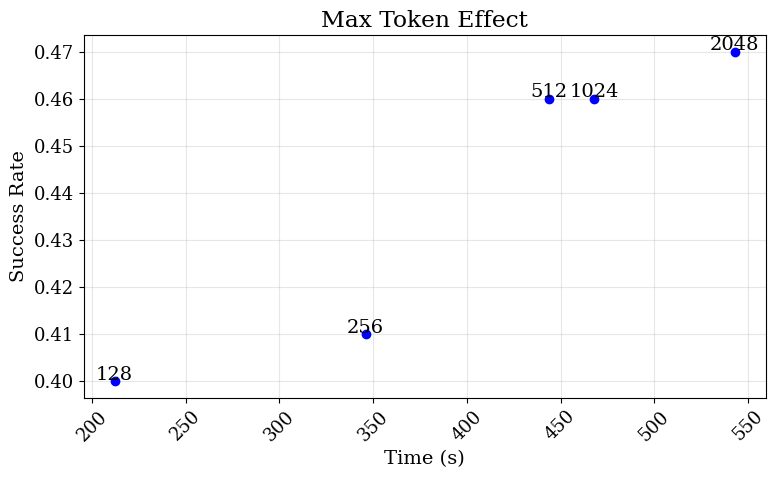

In [43]:
plt.figure(figsize=(8, 5))
array1 = [results['sa_3b_8b_100_halftime_t128'], results['sa_3b_8b_100_halftime_t256'], results['sa_3b_8b_100_halftime_t512'], results['sa_3b_8b_100_halftime_t1024'],results['sa_3b_8b_100_halftime_3']]
array2 = [212, 346, 444, 468 ,543]
plt.plot(array2, array1, 'o', color='b')
for x, y, label in zip(array2, array1, [128, 256, 512, 1024, 2048]):
    plt.annotate(str(label), (x, y), textcoords="offset points", xytext=(0,1), ha='center')
plt.xlabel('Time (s)')
plt.ylabel('Success Rate')
plt.title('Max Token Effect')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

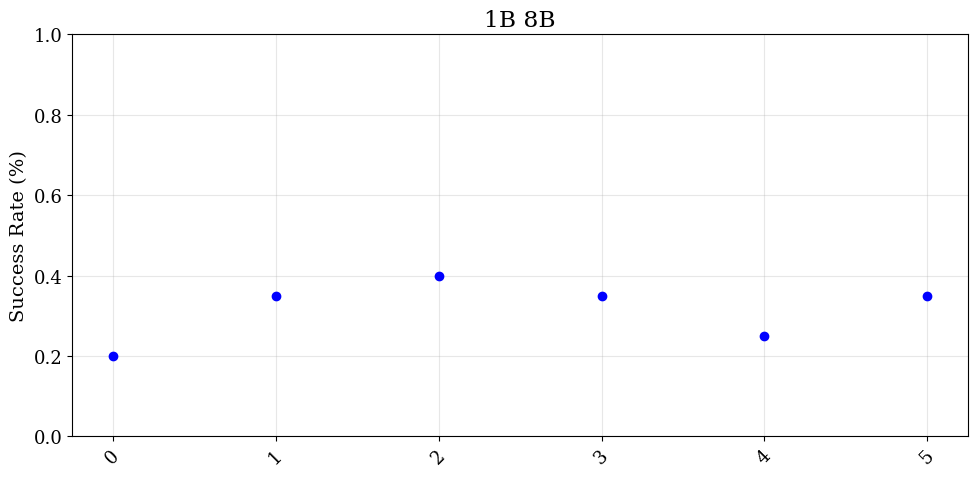

In [46]:
plt.figure(figsize=(10, 5))
array1 = [results['sa_1b_8b_1'], results['sa_1b_8b_2'], results['sa_1b_8b_3'], results['sa_1b_8b_4'], results['sa_1b_8b_5'], results['sa_1b_8b_6']]
plt.plot(array1, 'o', color='b')
# for x, y, label in zip(array2, array1, ['4', '16', '24', '4', '4', '4']):
#     plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 1)
plt.title('1B 8B')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


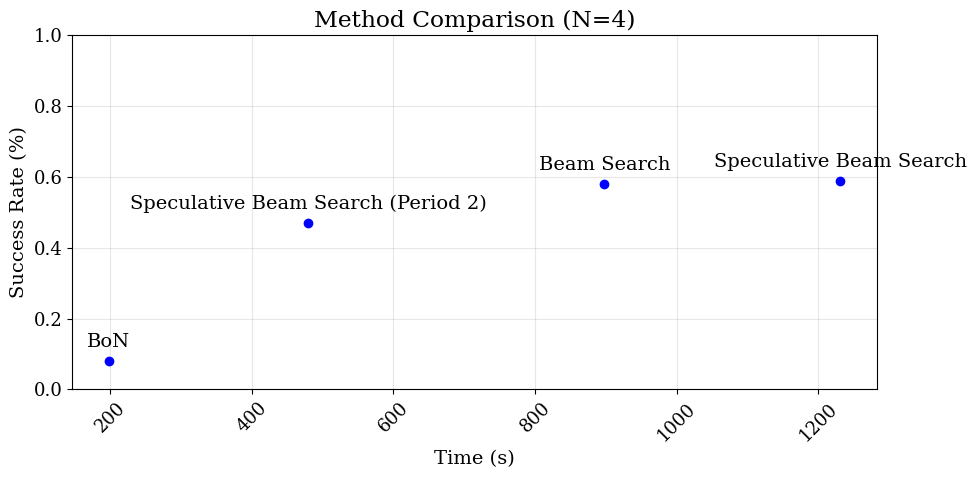

In [13]:
plt.figure(figsize=(10, 5))
array1 = [evals['best_of_n'], evals['beam_search'], evals['speculative_beam_search'], results['sa_3b_8b_100_halftime_3']]
array2 = [198, 898, 1231, 480]
plt.plot(array2, array1, 'o', color='b')
for x, y, label in zip(array2, array1, ['BoN', 'Beam Search', 'Speculative Beam Search', 'Speculative Beam Search (Period 2)']):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Time (s)')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 1)
plt.title('Method Comparison (N=4)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#1B model alone
#1B 8B
#8B alone
#8B BoN, N=4
# Beam Search, N=4, 8B and 1B
#8B Speculative Beam Search, N=4
#8B Speculative Beam Search, N=4, Half Time
#8B Speculative Beam Search, N=4, alter reward and large model usage

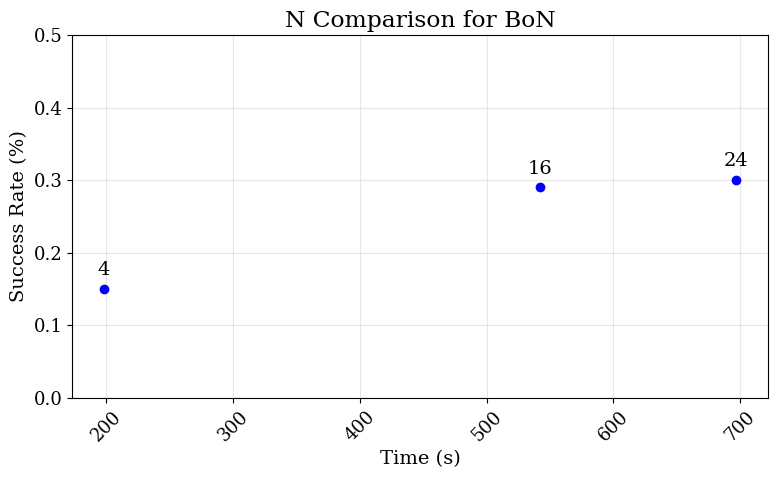

In [39]:
plt.figure(figsize=(8, 5))
array1 = [results['bon_1b_8b_1'], results['bon_1b_8b_2'], results['bon_1b_8b_3']]
array2 = [198, 542, 697]
plt.plot(array2, array1, 'o', color='b')
for x, y, label in zip(array2, array1, ['4', '16', '24']):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Time (s)')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 0.5)
plt.title('N Comparison for BoN')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()